# Import Libraries & Load Data

In [23]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.applications.densenet import DenseNet201
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
#from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import warnings
warnings.simplefilter("ignore")

In [24]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))          
            IMG.append(np.array(img))
            
    return IMG

benign_train = np.array(Dataset_loader('/kaggle/input/breast-cancer-diagnosis/breast-cancer-dataset/Train/Benign',224))
malign_train = np.array(Dataset_loader('/kaggle/input/breast-cancer-diagnosis/breast-cancer-dataset/Train/Malignant',224))
benign_test = np.array(Dataset_loader('/kaggle/input/breast-cancer-diagnosis/breast-cancer-dataset/Test/Benign',224))
malign_test = np.array(Dataset_loader('/kaggle/input/breast-cancer-diagnosis/breast-cancer-dataset/Test/Malignant',224))

100%|██████████| 120/120 [00:01<00:00, 103.53it/s]


In [25]:
benign_train.shape

(640, 224, 224, 3)

# Data Preprocessing

In [26]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

In [27]:
# Merge data 
x_train = np.concatenate((benign_train, malign_train), axis = 0)
y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
x_test = np.concatenate((benign_test, malign_test), axis = 0)
y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [28]:
# Shuffle train data
s = np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train = x_train[s]
y_train = y_train[s]

In [29]:
# Shuffle test data
s = np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test = x_test[s]
y_test = y_test[s]

In [30]:
# To categorical
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [31]:
# split dataset into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.2, 
    random_state=11
)

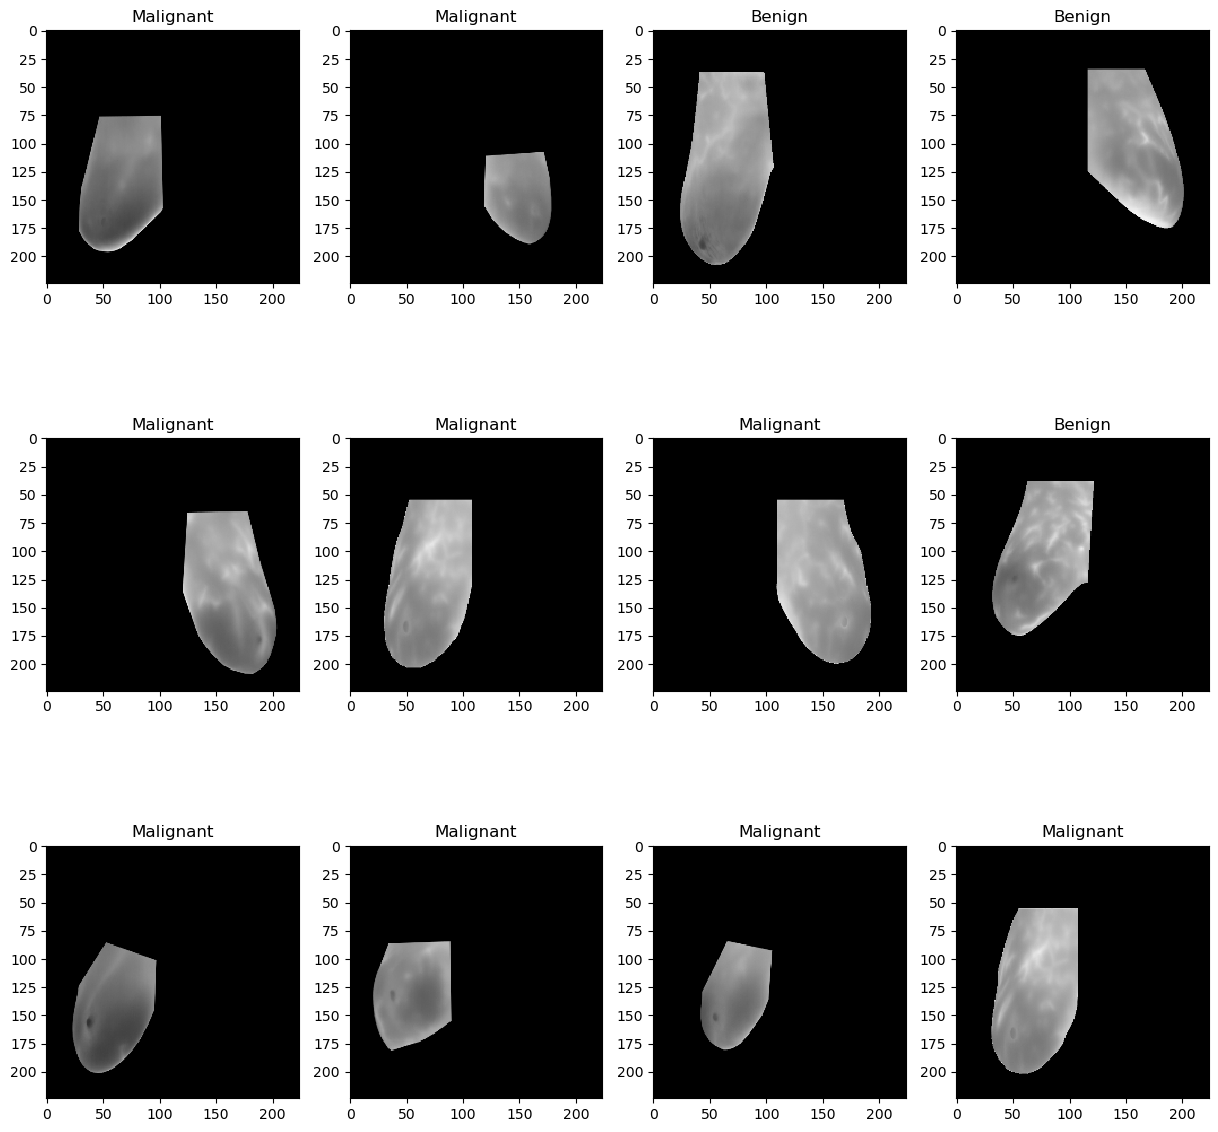

In [32]:
# visualization image
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [33]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Define Model

In [34]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

res = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
# resnet = DenseNet201(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224,224,3)
)

model = build_model(res ,lr = 1e-4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_189 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,815,074
Trainable params: 21,776,546


# Training & Evaluation

In [35]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                verbose=1,factor=0.2, min_lr=1e-7)


history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=(x_val, y_val),
)

Epoch 1/100
64/64 [==============================] - 51s 248ms/step - loss: 0.3075 - accuracy: 0.5820 - val_loss: 0.5312 - val_accuracy: 0.4688
Epoch 2/100
64/64 [==============================] - 15s 230ms/step - loss: 0.2434 - accuracy: 0.6543 - val_loss: 0.5312 - val_accuracy: 0.4688
Epoch 3/100
64/64 [==============================] - 15s 229ms/step - loss: 0.2492 - accuracy: 0.6406 - val_loss: 0.5142 - val_accuracy: 0.4688
Epoch 4/100
64/64 [==============================] - 15s 229ms/step - loss: 0.1936 - accuracy: 0.7363 - val_loss: 0.3689 - val_accuracy: 0.5508
Epoch 5/100
64/64 [==============================] - 15s 229ms/step - loss: 0.1778 - accuracy: 0.7725 - val_loss: 0.1944 - val_accuracy: 0.7891
Epoch 6/100
64/64 [==============================] - 15s 229ms/step - loss: 0.1896 - accuracy: 0.7314 - val_loss: 0.2548 - val_accuracy: 0.6484
Epoch 7/100
64/64 [==============================] - 15s 228ms/step - loss: 0.2064 - accuracy: 0.7314 - val_loss: 0.3141 - val_accuracy:

<Axes: >

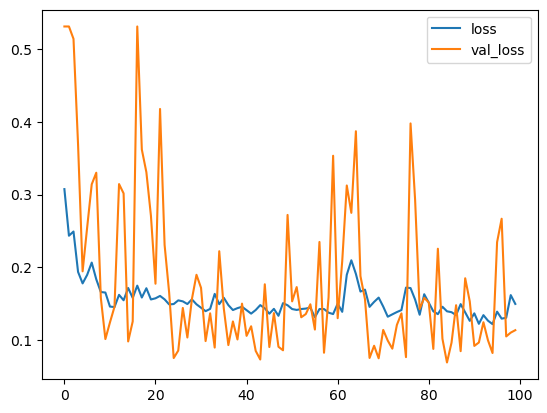

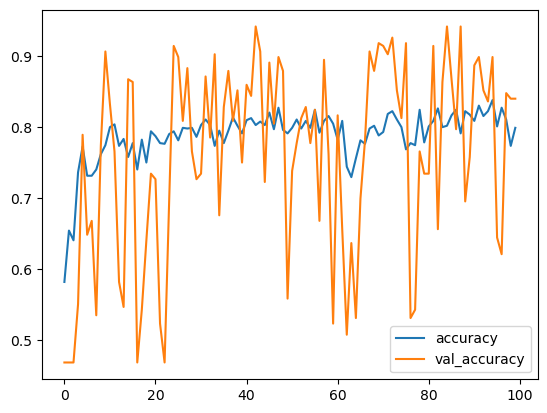

In [36]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

# Prediction

In [37]:
y_val_pred = model.predict(x_val)

8/8 [==============================] - 2s 73ms/step


In [38]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

0.83984375

In [39]:
y_pred = model.predict(x_test)

8/8 [==============================] - 2s 59ms/step


In [40]:
steps = 10
predictions = []

for i in tqdm(range(steps)):
    preds = model.predict_generator(train_generator.flow(x_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(x_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [00:39<00:00,  3.96s/it]


# Confusion Matrix

Confusion matrix, without normalization
[[117   3]
 [ 63  57]]


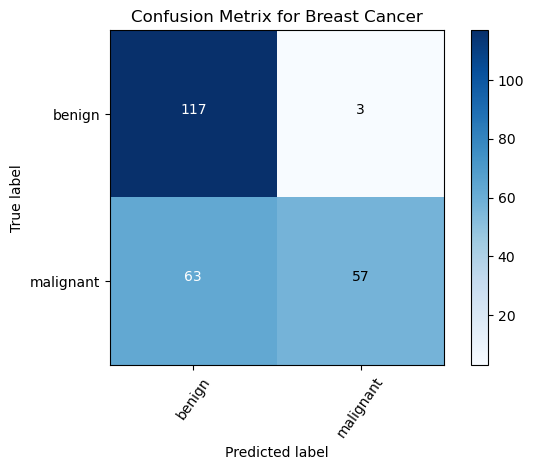

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

Confusion matrix, without normalization
[[115   5]
 [ 68  52]]


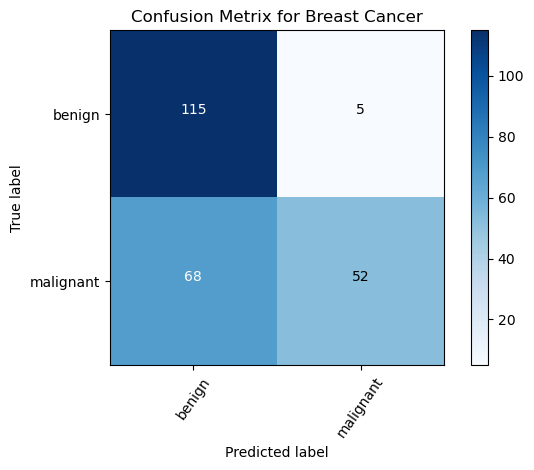

In [42]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

# Classification Report

In [43]:
from sklearn.metrics import classification_report
classification_report( np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.63      0.96      0.76       120\n           1       0.91      0.43      0.59       120\n\n    accuracy                           0.70       240\n   macro avg       0.77      0.70      0.67       240\nweighted avg       0.77      0.70      0.67       240\n'

# ROC & AUC

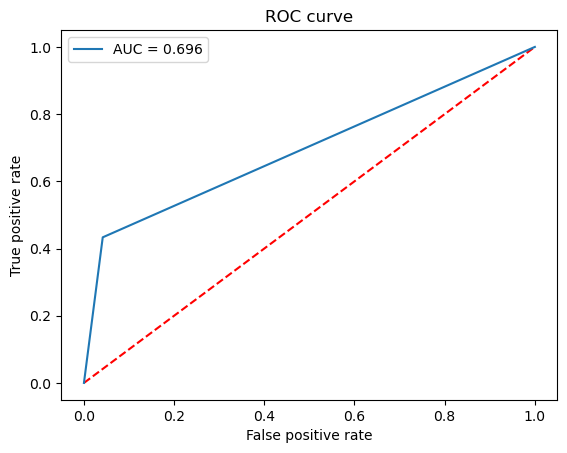

In [44]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()